# Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [56]:
import pandas as pd
import numpy as np

In [2]:
dataset = MNIST(root = './data', download=True, transform=ToTensor())

In [3]:
def check_dataset(dataset):
    image, label = dataset[0]
    print('Image.Shape: ', image.shape)
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    print("Label: ", label)

Image.Shape:  torch.Size([1, 28, 28])
Label:  5


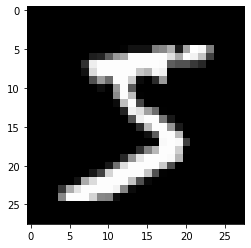

In [4]:
check_dataset(dataset)

# Split Dataset

In [5]:
def split_dataset(val_size, dataset):
    train_size = len(dataset) - val_size
    
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    return train_ds, val_ds

In [8]:
train_ds, val_ds = split_dataset(10000, dataset)
len(train_ds), len(val_ds)

(50000, 10000)

In [23]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [24]:
batch_size = 128

In [25]:
def batch_image_view(dataset_loader):
    for images, label in dataset_loader:
        print("Image.Shape: ", images.shape)
        plt.figure(figsize = (16, 8))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break    

Image.Shape:  torch.Size([128, 1, 28, 28])


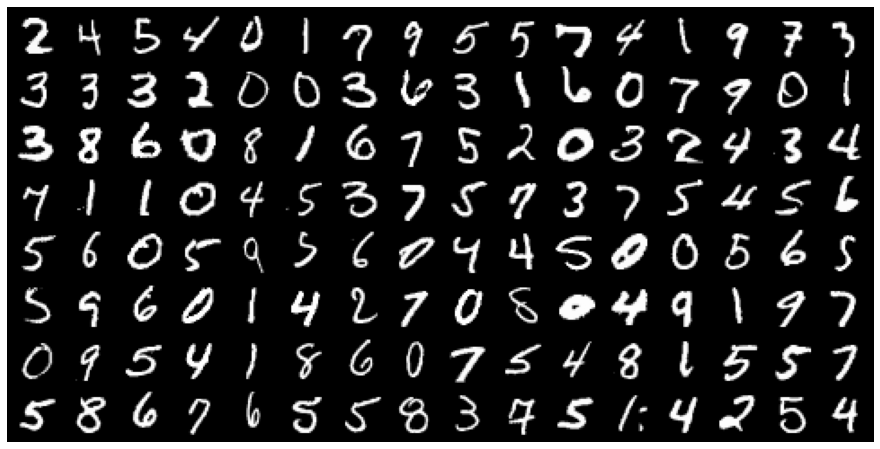

In [26]:
batch_image_view(train_loader)

# Model

In [27]:
class MNISTModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
input_size = 28*28
hidden_size = 32
num_classes = 10

# Using GPU

In [30]:
def check_device():
    return torch.cuda.is_available()

In [31]:
check_device()

True

In [32]:
def get_default_device():
    if check_device():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [35]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [36]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [37]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [38]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
model = MNISTModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MNISTModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [40]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.29654860496521, 'val_acc': 0.11269531399011612}]

In [41]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2316, val_acc: 0.9318
Epoch [1], val_loss: 0.1905, val_acc: 0.9419
Epoch [2], val_loss: 0.1472, val_acc: 0.9556
Epoch [3], val_loss: 0.1319, val_acc: 0.9610
Epoch [4], val_loss: 0.1288, val_acc: 0.9598
Epoch [5], val_loss: 0.1165, val_acc: 0.9648
Epoch [6], val_loss: 0.1086, val_acc: 0.9678
Epoch [7], val_loss: 0.1167, val_acc: 0.9628
Epoch [8], val_loss: 0.1669, val_acc: 0.9484
Epoch [9], val_loss: 0.1052, val_acc: 0.9683


In [42]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0948, val_acc: 0.9720
Epoch [1], val_loss: 0.0948, val_acc: 0.9714
Epoch [2], val_loss: 0.0958, val_acc: 0.9713
Epoch [3], val_loss: 0.0957, val_acc: 0.9707
Epoch [4], val_loss: 0.0950, val_acc: 0.9715
Epoch [5], val_loss: 0.0965, val_acc: 0.9705
Epoch [6], val_loss: 0.0967, val_acc: 0.9699
Epoch [7], val_loss: 0.0951, val_acc: 0.9696
Epoch [8], val_loss: 0.0974, val_acc: 0.9709
Epoch [9], val_loss: 0.0958, val_acc: 0.9706


# Loss Plot

Text(0.5, 1.0, 'loss vs no. of epochs')

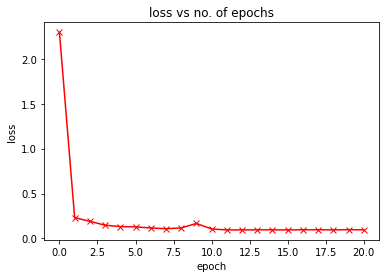

In [44]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs no. of epochs')

# Accuracy Plot

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

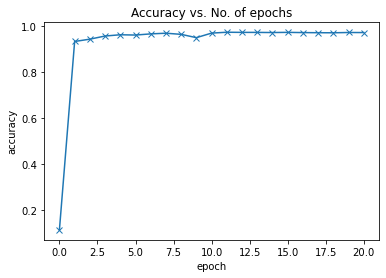

In [45]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [46]:
history[-1]

{'val_loss': 0.095842145383358, 'val_acc': 0.9706054925918579}

In [47]:
len(history)

21

# Save the Model

In [48]:
torch.save(model.state_dict(), 'model/mnist-neural-network-3.pth')

# Load the Model

In [49]:
model2 = MNISTModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [50]:
model2.load_state_dict(torch.load('model/mnist-neural-network-3.pth'))

<All keys matched successfully>

In [51]:
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0029,  0.0198, -0.0071,  ...,  0.0021,  0.0313, -0.0322],
                      [ 0.0136, -0.0181,  0.0184,  ...,  0.0318, -0.0007,  0.0011],
                      [-0.0290,  0.0284,  0.0197,  ...,  0.0277, -0.0262, -0.0114],
                      ...,
                      [-0.0258,  0.0181,  0.0092,  ...,  0.0015,  0.0090, -0.0271],
                      [-0.0198,  0.0268,  0.0074,  ..., -0.0287, -0.0064, -0.0118],
                      [-0.0069,  0.0246, -0.0224,  ...,  0.0344,  0.0012,  0.0339]])),
             ('linear1.bias',
              tensor([ 0.0436, -0.0105,  0.1728, -0.1427, -0.3850, -0.1394,  0.3574, -0.1232,
                       0.2565,  0.7163,  0.2292,  0.0823,  0.3336, -0.1946, -0.0735,  0.4488,
                      -0.0581,  0.1253,  0.0549, -0.0382, -0.4729,  0.2909,  0.5761,  0.2281,
                       0.0834,  0.0107,  0.0220, -0.4019,  0.0383,  0.6935, -0.1752, -0.3244])),
             ('linear2.we

# Testing with Individual Images

In [52]:
test_dataset = MNIST(root='./data', train=False, transform=ToTensor())

In [53]:
def predict_image(img, model):
    xb = img.unsqueeze(0) # used to flatten the image
    print("xb.shape: ", xb.shape)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [54]:
def predict_series_images(test_dataset, max_count=10):
    OG_LABEL, PRED_LABEL = [], []
    for count, (img, label) in enumerate(test_dataset):
        if count < max_count:
            OG_LABEL.append(label)
            img = img.unsqueeze(0)
            yb = model2(img)
            _, preds = torch.max(yb, dim=1)
            PRED_LABEL.append(preds[0].item())       
    return torch.tensor(OG_LABEL), torch.tensor(PRED_LABEL)

In [55]:
og_label, pred_label = predict_series_images(test_dataset, max_count=20)
print(og_label)
print(pred_label)
print('accuracy: ', (torch.sum(og_label == pred_label)/len(og_label)).item())

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
accuracy:  1


In [57]:
og_label, pred_label = og_label.numpy(), pred_label.numpy()

In [58]:
output_dataframe = pd.DataFrame({'Original Label': og_label[:], 'Predicted Label': pred_label[:]})
print(output_dataframe)
print(f"Accuracy: {(np.sum(og_label == pred_label)/ len(og_label)) * 100}%")

    Original Label  Predicted Label
0                7                7
1                2                2
2                1                1
3                0                0
4                4                4
5                1                1
6                4                4
7                9                9
8                5                5
9                9                9
10               0                0
11               6                6
12               9                9
13               0                0
14               1                1
15               5                5
16               9                9
17               7                7
18               3                3
19               4                4
Accuracy: 100.0%
